<a href="https://colab.research.google.com/github/Sahana-M/self-driving-car/blob/master/Traffic_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [127]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

In [0]:
np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
 
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
  
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [0]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
 

In [174]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

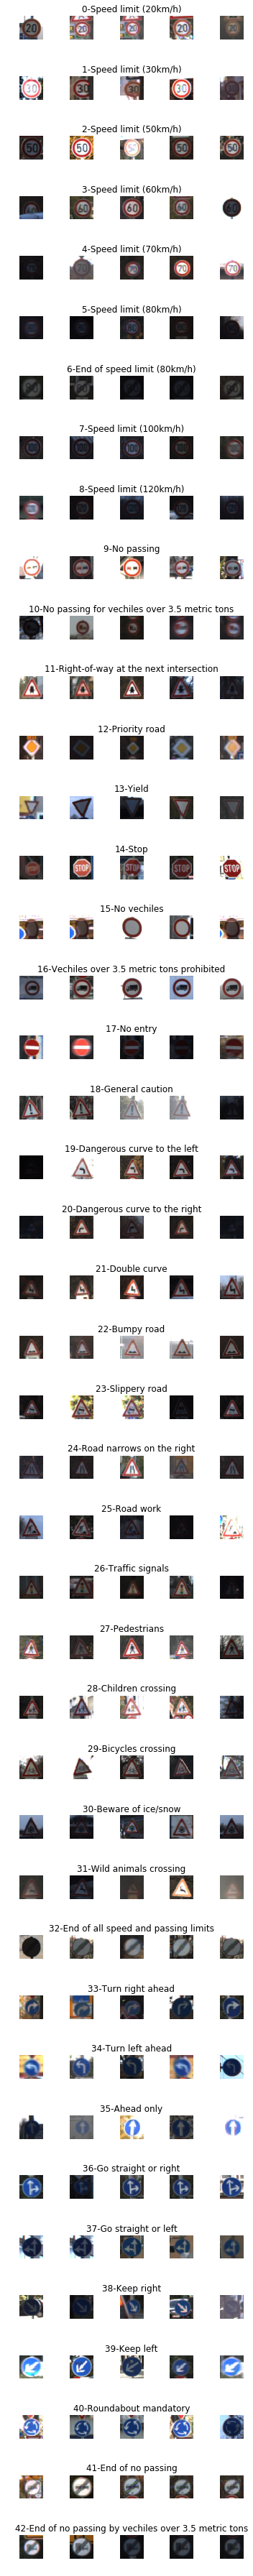

In [176]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" +row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

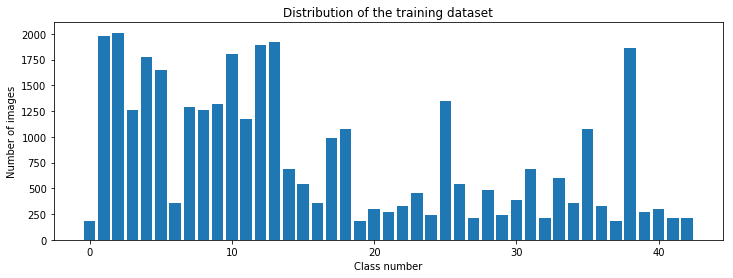

In [177]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


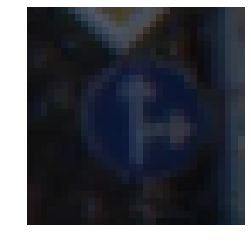

In [178]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])


(32, 32)


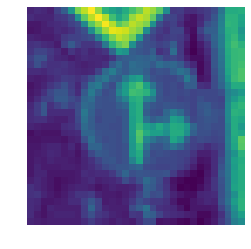

In [179]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)



(32, 32)


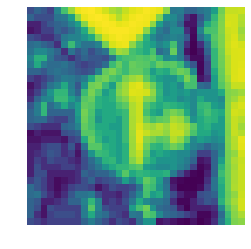

In [180]:

def equalize(img):
    img = cv2.equalizeHist(img)
    return img
  
  
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

(34799, 32, 32)


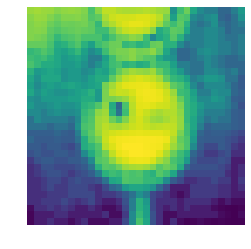

In [181]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))
 
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [0]:
#data augumentation

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                              zoom_range = 0.2,
                              shear_range = 0.1,
                              rotation_range = 10)

datagen.fit(X_train)

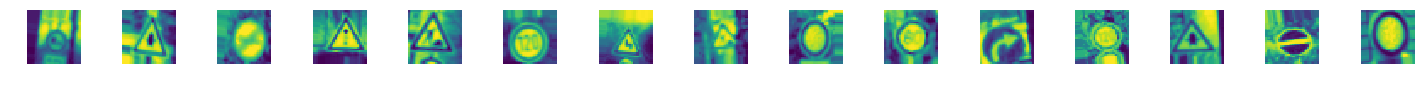

In [184]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [0]:
y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_val = to_categorical(y_val, 43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(60, (5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  
  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(Conv2D(30, (3,3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
 # model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation = 'softmax'))
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
  return model
  

In [244]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 480)               0         
__________

In [245]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data = (X_val, y_val), shuffle = 1)


Epoch 1/10
2000/2000 [==============================] - 57s 29ms/step - loss: 0.8770 - acc: 0.7445 - val_loss: 0.0864 - val_acc: 0.9705
Epoch 2/10
2000/2000 [==============================] - 56s 28ms/step - loss: 0.2157 - acc: 0.9334 - val_loss: 0.0604 - val_acc: 0.9814
Epoch 3/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.1460 - acc: 0.9546 - val_loss: 0.0401 - val_acc: 0.9866
Epoch 4/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.1190 - acc: 0.9636 - val_loss: 0.0210 - val_acc: 0.9948
Epoch 5/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.0938 - acc: 0.9713 - val_loss: 0.0397 - val_acc: 0.9871
Epoch 6/10
2000/2000 [==============================] - 55s 28ms/step - loss: 0.0855 - acc: 0.9740 - val_loss: 0.0260 - val_acc: 0.9925
Epoch 7/10
2000/2000 [==============================] - 55s 27ms/step - loss: 0.0760 - acc: 0.9771 - val_loss: 0.0317 - val_acc: 0.9909
Epoch 8/10
2000/2000 [==========================

Text(0.5, 0, 'epoch')

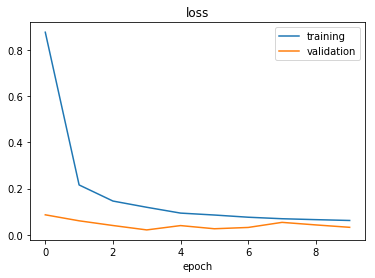

In [246]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')


Text(0.5, 0, 'epoch')

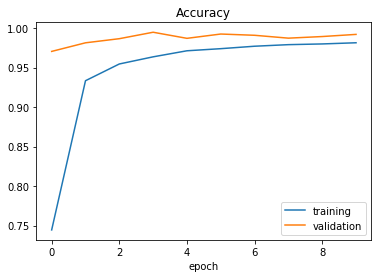

In [247]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [248]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('test score :', score[0])
print('accuracy :', score[1])

test score : 0.08945623158958002
accuracy : 0.978147268455744


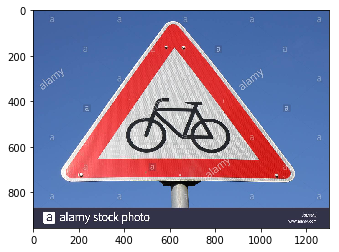

In [273]:
import requests 
from PIL import Image 
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True) 
img = Image.open(r.raw) 
plt.imshow(img, cmap=plt.get_cmap('gray'))



(32, 32)


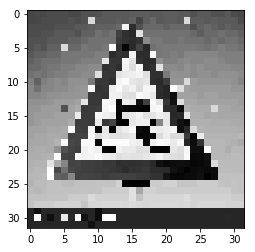

In [274]:

#Preprocess image
img = np.asarray(img) 
img = cv2.resize(img, (32, 32)) 
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape) 



In [275]:

#Reshape reshape 
img = img.reshape(1, 32, 32, 1)


#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [30]
